<a href="https://colab.research.google.com/github/davemlz/eemont/blob/master/tutorials/014-Time-Series-By-Regions-Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series By Regions (with Conversion to Pandas and Visualization with Seaborn) using EEMONT, GEETOOLS and GEEMAP

- GitHub Repo: [https://github.com/davemlz/eemont](https://github.com/davemlz/eemont)
- PyPI link: [https://pypi.org/project/eemont/](https://pypi.org/project/eemont/)
- Documentation: [https://eemont.readthedocs.io/en/0.1.8/index.html](https://eemont.readthedocs.io/en/0.1.8/index.html)
- More tutorials: [https://github.com/davemlz/eemont/tree/master/tutorials](https://github.com/davemlz/eemont/tree/master/tutorials)

## Let's start!

NOTE: before running this notebook, pass the following commands to a Python terminal. (File, New, Terminal)

Return to this notebook and Import the required packges.

In [11]:
import ee, eemont, geemap
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# import geetools for cloud /sadow discrimination
from geetools import ui, cloud_mask


Authenticate and Initialize Earth Engine and geemap.

In [12]:
Map = geemap.Map()
Map.add_basemap('Esri Satellite')
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Let's use some center-pivot crops in Utah:

In [13]:
pivot0=ee.Geometry.Point([-117.0856069587170, 36.1797210294753]).buffer(10) #the number in buffer is the radius for the center pivot
pivot1=ee.Geometry.Point([-117.0884979609400,36.1734460014849]).buffer(10)
pivot2=ee.Geometry.Point([-117.0888227596870,36.1736295651644]).buffer(10)
pivot3=ee.Geometry.Point([-117.0874020000000,36.1736690000000]).buffer(10)

Map.addLayer(pivot0,{},'pine0')
Map.addLayer(pivot1,{},'pine1')
Map.addLayer(pivot2,{},'pine2')
Map.addLayer(pivot3,{},'pine3')

Map.centerObject(pivot0,12)


Let's combine the different center pivot features into a Feature Collection

In [14]:
pivots = ee.FeatureCollection([
    ee.Feature(pivot0,{'pine':0}),
    ee.Feature(pivot1,{'pine':1}),
    ee.Feature(pivot2,{'pine':2}),
    ee.Feature(pivot3,{'pine':3})
])

Let's pre-process and process our image collection; LANDSAT 8

In [15]:
L8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(pivots).filter(ee.Filter.date('2018-01-01', '2020-12-01'))


In [16]:
# CLOUD MASKING IN EE PYTHON NOT QUITE EASY. USING THE GEETOOLS custom functions https://github.com/gee-community/gee_tools 

# this function only for Landsat 8 Surface Corrected single image
mask_l8SR_all = cloud_mask.landsatSR() #this function masks clouds, snow, shadows

# mask_l8SR_cloud = cloud_mask.landsatSR(['cloud'])
# mask_l8SR_shadow = cloud_mask.landsatSR(['shadow'])
# mask_l8SR_snow = cloud_mask.landsatSR(['snow'])

In [17]:
# creating a function for masking the entire ImmageCollection
def maskL8sr(image):
    cld_free=mask_l8SR_all(image)
    return cld_free

NOTE check eemont repository for examples of maskCLouds, scale, and application of vegetation indexes. https://eemont.readthedocs.io/en/latest/guide/spectralIndices.html

In [18]:
L8 = L8.map(maskL8sr).scale().index(['kNDVI','NDVI','SAVI'])

Let's check which bands are available.

In [19]:
L8.first().bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B10',
 'B11',
 'sr_aerosol',
 'pixel_qa',
 'radsat_qa']

## Time Lapse of the Satellite data

Using Geemap example 72

In [10]:
collection = L8.select("NDVI").filter(ee.Filter.date('2020-04-01', '2020-12-01')).sort('system:time_start')

vis_params = {
  'min': 0.0,
  'max': 1.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

first_image = collection.first()

Map.addLayer(first_image, vis_params, "First image")
# Map.setCenter(-7.03125, 31.0529339857, 2)
Map

EEException: Collection.first: Error in map(ID=LC08_040035_20200407):
Image.select: Pattern 'NDVI' did not match any bands.

In [14]:
# image = collection.toBands()
# Map.addLayer(image, {}, "Time series", False)

In [36]:
labels = collection.aggregate_array("system:index").getInfo()
Map.add_time_slider(collection, vis_params, labels=labels, time_interval=1)

## Time Series By Regions

Let's get the L8 time series for our buffer. Checklist:

- Image Collection: The Landsat 8 collection.
- Bands to use for the time series: GNDVI and EVI.
- Feature Collection: Our center-pivot crops.
- Statistics to compute: Mean and Median.
- Scale: 30 m.

In [16]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['kNDVI','NDVI','SAVI'],
                               reducer = [ee.Reducer.mean()],
                               scale = 30)

## Conversion to Pandas

The time series is retrieved as a feature collection. To convert it to a pandas dataframe we'll use `geemap` (This may take a little bit):

In [17]:
tsPandas = geemap.ee_to_pandas(ts)

Let's check our pandas data frame:

In [18]:
tsPandas

,NDVI,SAVI,date,kNDVI,pine,reducer
0,-9999.000000,-9999.000000,2018-01-12T18:21:49,-9999.000000,0,mean
1,-9999.000000,-9999.000000,2018-01-12T18:21:49,-9999.000000,1,mean
2,0.002846,0.000851,2018-01-12T18:21:49,0.000008,2,mean
3,-9999.000000,-9999.000000,2018-01-12T18:21:49,-9999.000000,3,mean
4,-9999.000000,-9999.000000,2018-01-28T18:21:40,-9999.000000,0,mean
...,...,...,...,...,...,...
515,0.183735,0.078960,2020-10-23T18:28:16,0.033812,3,mean
516,0.348131,0.054901,2020-11-24T18:28:16,0.120605,0,mean
517,0.176436,0.072240,2020-11-24T18:28:16,0.031179,1,mean
518,0.279577,0.055575,2020-11-24T18:28:16,0.082124,2,mean


What can we see here?

- The values for each band (GNDVI and EVI) are in separated columns.
- There are some -9999 values in the GNDVI and EVI columns. These values represent the NA values (e.g. Clouds or shadows). The -9999 can be changed by modifying the `naValue` parameter in the `getTimeSeriesByRegion` method (e.g. `naValue = -10000`).
- Multiple reducers can be used. In the output dataframe they are specified by a single column named `reducer`: mean, median.
- The date is a string that needs to be converted to a date data type.
- The attributes of the original feature collection are attached to the data frame: `pivot`.

Given this, let's curate our data frame!

First, let's get rid of the -9999 value:

In [19]:
tsPandas[tsPandas == -9999] = np.nan

And now, let's convert the date to a date data type:

In [20]:
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

We can also gather the GNDVI and EVI columns into a single column to make the data frame more 'tidy-er' (This is optional):

In [21]:
tsPandas = pd.melt(tsPandas,
                   id_vars = ['reducer','date','pine'],
                   value_vars = ['NDVI','SAVI'],
                   var_name = 'Index',
                   value_name = 'Value')

Let's check our curated data frame:

In [22]:
# tsPandas[tsPandas['Value'] > 1] = np.nan
tsPandas[tsPandas['Value'] < 0] = np.nan

tsPandas

,reducer,date,pine,Index,Value
0,mean,2018-01-12 18:21:49,0.0,NDVI,NaN
1,mean,2018-01-12 18:21:49,1.0,NDVI,NaN
2,mean,2018-01-12 18:21:49,2.0,NDVI,0.002846
3,mean,2018-01-12 18:21:49,3.0,NDVI,NaN
4,mean,2018-01-28 18:21:40,0.0,NDVI,NaN
...,...,...,...,...,...
1035,mean,2020-10-23 18:28:16,3.0,SAVI,0.078960
1036,mean,2020-11-24 18:28:16,0.0,SAVI,0.054901
1037,mean,2020-11-24 18:28:16,1.0,SAVI,0.072240
1038,mean,2020-11-24 18:28:16,2.0,SAVI,0.055575


## Visualization

Now, let's visualize our time series using `seaborn`:

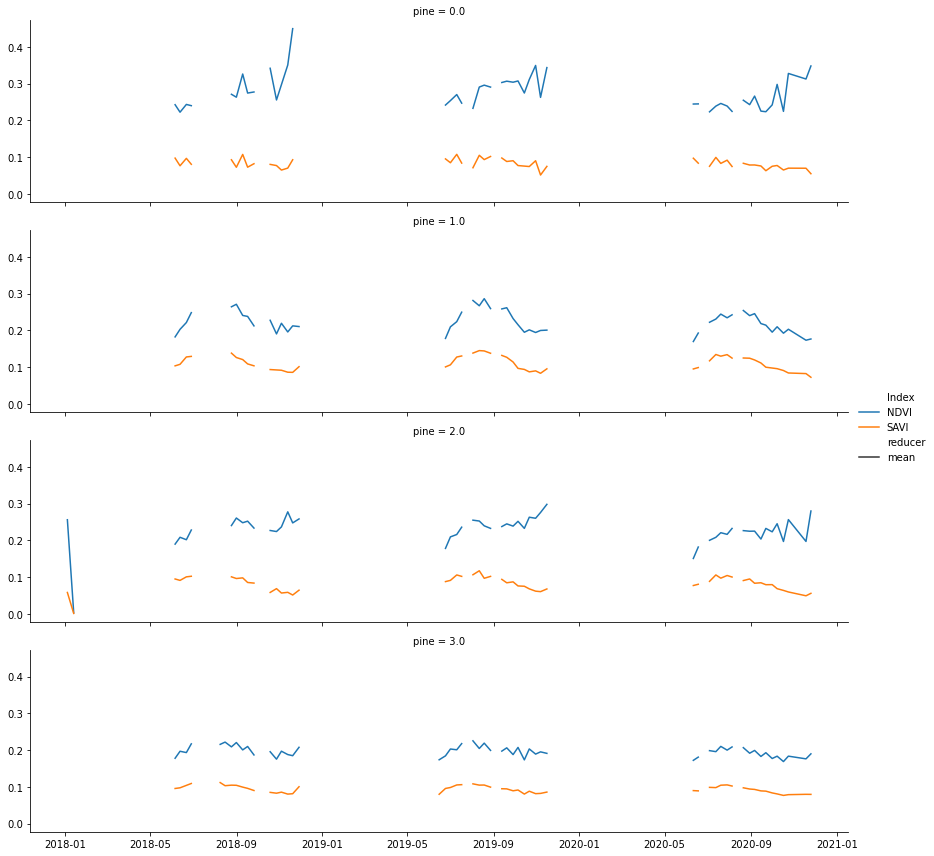

In [23]:
g = sns.FacetGrid(tsPandas,row = 'pine',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()

Let's do the same, but now for radiometric temperature (two bands, B10 and B11).

In [24]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['B10','B11'],
                               reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                               scale = 30)

In [25]:
tsPandas2 = geemap.ee_to_pandas(ts)

In [26]:
tsPandas2

,B10,B11,date,pine,reducer
0,-9999.0,-9999.0,2018-01-12T18:21:49,0,mean
1,-9999.0,-9999.0,2018-01-12T18:21:49,1,mean
2,268.1,268.3,2018-01-12T18:21:49,2,mean
3,-9999.0,-9999.0,2018-01-12T18:21:49,3,mean
4,-9999.0,-9999.0,2018-01-28T18:21:40,0,mean
...,...,...,...,...,...
1035,295.0,295.2,2020-10-23T18:28:16,3,median
1036,275.1,276.2,2020-11-24T18:28:16,0,median
1037,276.3,276.3,2020-11-24T18:28:16,1,median
1038,274.1,275.1,2020-11-24T18:28:16,2,median


In [27]:
tsPandas2[tsPandas2 == -9999] = np.nan

tsPandas2['date'] = pd.to_datetime(tsPandas2['date'],infer_datetime_format = True)

In [28]:
tsPandas2 = pd.melt(tsPandas2,
                   id_vars = ['reducer','date','pine'],
                   value_vars = ['B10','B11'],
                   var_name = 'Index',
                   value_name = 'Value')

In [29]:
tsPandas2

,reducer,date,pine,Index,Value
0,mean,2018-01-12 18:21:49,0,B10,NaN
1,mean,2018-01-12 18:21:49,1,B10,NaN
2,mean,2018-01-12 18:21:49,2,B10,268.1
3,mean,2018-01-12 18:21:49,3,B10,NaN
4,mean,2018-01-28 18:21:40,0,B10,NaN
...,...,...,...,...,...
2075,median,2020-10-23 18:28:16,3,B11,295.2
2076,median,2020-11-24 18:28:16,0,B11,276.2
2077,median,2020-11-24 18:28:16,1,B11,276.3
2078,median,2020-11-24 18:28:16,2,B11,275.1


Visualization

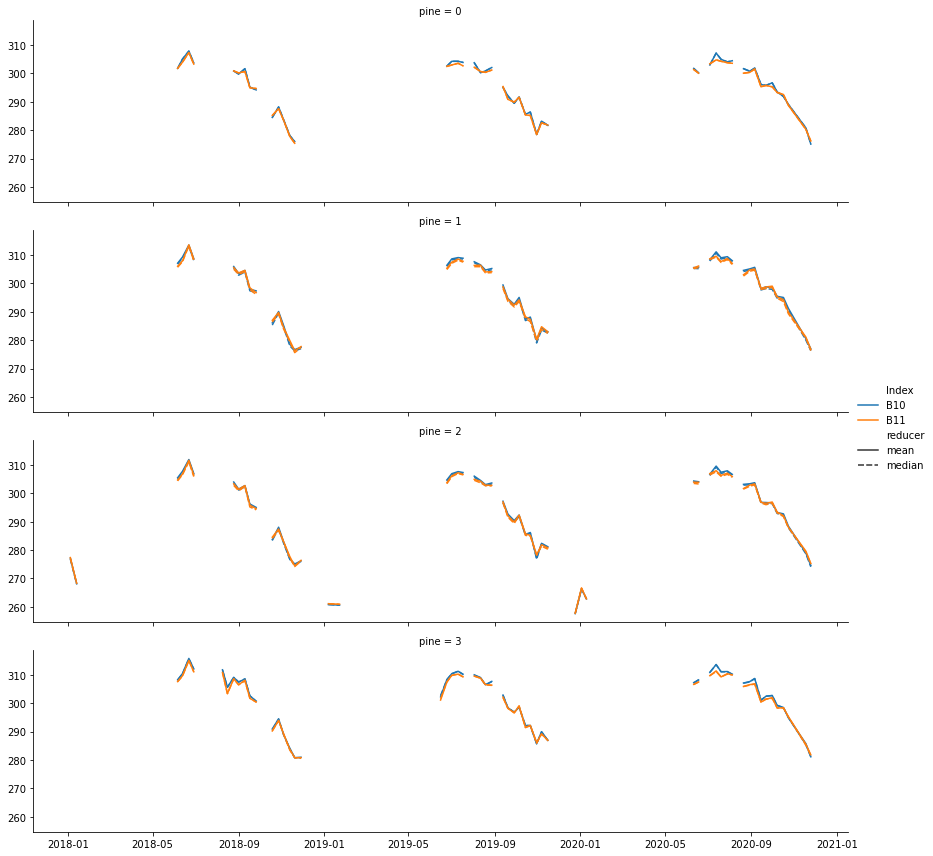

In [30]:
g = sns.FacetGrid(tsPandas2,row = 'pine',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()

Is there any relationship between NDVI and temperature?

In [31]:
dfinal = tsPandas.merge(tsPandas2, on=['date','reducer','pine'])
dfinal

,reducer,date,pine,Index_x,Value_x,Index_y,Value_y
0,mean,2018-01-12 18:21:49,0.0,NDVI,NaN,B10,NaN
1,mean,2018-01-12 18:21:49,0.0,NDVI,NaN,B11,NaN
2,mean,2018-01-12 18:21:49,0.0,SAVI,NaN,B10,NaN
3,mean,2018-01-12 18:21:49,0.0,SAVI,NaN,B11,NaN
4,mean,2018-01-12 18:21:49,1.0,NDVI,NaN,B10,NaN
...,...,...,...,...,...,...,...
2063,mean,2020-11-24 18:28:16,2.0,SAVI,0.055575,B11,275.297674
2064,mean,2020-11-24 18:28:16,3.0,NDVI,0.190022,B10,281.129213
2065,mean,2020-11-24 18:28:16,3.0,NDVI,0.190022,B11,281.844944
2066,mean,2020-11-24 18:28:16,3.0,SAVI,0.079712,B10,281.129213


In [32]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pine'] == 0)& (dfinal['reducer'] == 'mean')]
select_color

,reducer,date,pine,Index_x,Value_x,Index_y,Value_y
0,mean,2018-01-12 18:21:49,0.0,NDVI,NaN,B10,NaN
16,mean,2018-01-28 18:21:40,0.0,NDVI,NaN,B10,NaN
32,mean,2018-02-13 18:21:34,0.0,NDVI,NaN,B10,NaN
48,mean,2018-03-01 18:21:27,0.0,NDVI,NaN,B10,NaN
64,mean,2018-03-17 18:21:18,0.0,NDVI,NaN,B10,NaN
...,...,...,...,...,...,...,...
1988,mean,2020-09-05 18:28:07,0.0,NDVI,0.266129,B10,301.9
2004,mean,2020-09-21 18:28:12,0.0,NDVI,0.223644,B10,295.8
2020,mean,2020-10-07 18:28:15,0.0,NDVI,0.297987,B10,293.5
2036,mean,2020-10-23 18:28:16,0.0,NDVI,0.327759,B10,289.1


<AxesSubplot:title={'center':'Pine 0'}, xlabel='Value_y', ylabel='Value_x'>

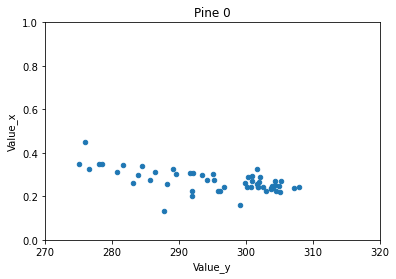

In [33]:
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Pine 0",xlim=(270,320),ylim=(0,1))

<AxesSubplot:title={'center':'Pine 1'}, xlabel='Value_y', ylabel='Value_x'>

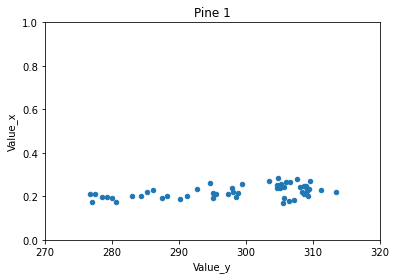

In [34]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pine'] == 1)& (dfinal['reducer'] == 'mean')]
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Pine 1",xlim=(270,320),ylim=(0,1))

<AxesSubplot:title={'center':'Pine 2'}, xlabel='Value_y', ylabel='Value_x'>

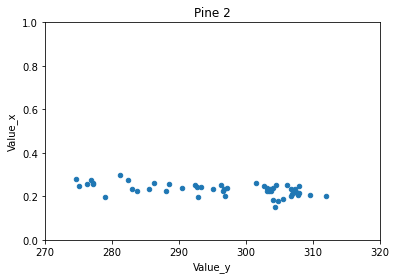

In [35]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pine'] == 2)& (dfinal['reducer'] == 'mean')]
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Pine 2",xlim=(270,320),ylim=(0,1),xlabel='B10',ylabel='NDVI')

## Assignment:
    
Create two notebooks, and in each notebook, change the center pivot locations, for the first one, select 3 center pivots around "El Amal, Markaz Abo El Matamier, Beheira" (Egypt) and the second notebook select 3 center pivots around  "Seminole, Texas". Please, discuss the time series variability in vegetation indices and temperatures between the two notebooks. What could be reasons for the found differences?

Happy Coding!
